# Лабораторная работа №5
## Выполнил Буканов Никита ПМ-21М
## Вариант 2

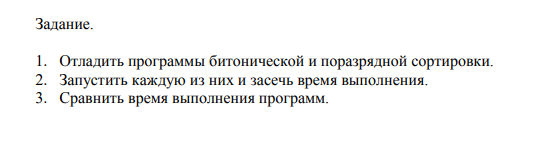

# Битоническая сортировка

```c++
#include <cstdio>
#include <cstdlib>
#include <iostream>
#include <cassert>
constexpr size_t BLOCK_SIZE = 1024; // Размер блока.
constexpr size_t SIZE = 2048;

// Отдельный компаратор  сравнивает пару ключей
// и производит обмен соответствующих элементов и
// ключей для обеспечения заданного порядка.
__device__ void Comparator (uint& keyA, uint& valA, uint& keyB, uint& valB, uint dir) {
  uint t;
  // Поменять местами (keyA, valA) и (keyB, valB)
  if ( (keyA > keyB) == dir ) {
    t = keyA;
    keyA = keyB;
    keyB = t;
    t = valA;
    valA = valB;
    valB = t;
  }
}

__global__ void bitonicSortShared (uint* dstKey,
                                   uint* dstVal,
                                   uint* srcKey,
                                   uint* srcVal,
                                   uint arrayLength,
                                   uint dir) {
  __shared__ uint sk [BLOCK_SIZE * 2];
  __shared__ uint sv [BLOCK_SIZE * 2];
  
  int index = blockIdx.x * BLOCK_SIZE * 2 + threadIdx.x;
  sk [threadIdx.x] = srcKey[index];
  sv [threadIdx.x] = srcVal[index];
  sk [threadIdx.x + BLOCK_SIZE] = srcKey [index + BLOCK_SIZE];
  sv [threadIdx.x + BLOCK_SIZE] = srcVal [index + BLOCK_SIZE];
  
  assert(threadIdx.x + BLOCK_SIZE < SIZE && index + BLOCK_SIZE < SIZE);

  for (uint size = 2; size < arrayLength; size <<= 1u )
  {
    // Битоническое слияние
    uint ddd = dir ^ ((threadIdx.x & (size / 2)) != 0);
    for (uint stride = size >> 1u; stride > 0; stride >>= 1u)
    {
      __syncthreads ();
      uint pos = 2 * threadIdx.x - (threadIdx.x & (stride - 1));
      assert(pos + stride < 2 * BLOCK_SIZE);
      Comparator( sk[pos], sv[pos], sk[pos+stride], sv[pos+stride], ddd);
    }
    __syncthreads();
  }

  for (uint stride = arrayLength >> 1u; stride > 0; stride >>= 1u)
  {
    __syncthreads ();
    uint pos = 2 * threadIdx.x - (threadIdx.x & (stride - 1));
    // assert(pos + stride < 2 * BLOCK_SIZE);
    Comparator( sk[pos], sv[pos], sk[pos + stride], sv[pos+stride], dir);
  }
  __syncthreads ();
  dstKey[index] = sk[threadIdx.x] ;
  dstVal[index] = sv[threadIdx.x] ;
  dstKey[index + BLOCK_SIZE] = sk[threadIdx.x + BLOCK_SIZE];
  dstVal[index + BLOCK_SIZE] = sv[threadIdx.x + BLOCK_SIZE];
}


__host__ int main()
{
  uint* key_arr = new uint[SIZE];
  uint* value_arr = new uint[SIZE];

  for (size_t i=0; i<SIZE; i++)
  {
    key_arr[i] = uint(rand()) % 100;
    value_arr[i] = i;
  }
  
  uint* dst_key_arr = new uint[SIZE];
  cudaMalloc((void **)&dst_key_arr, SIZE * sizeof(uint));
  
  uint* dst_value_arr = new uint[SIZE];
  cudaMalloc((void **)&dst_value_arr, SIZE * sizeof(uint));

  uint* cuda_key_arr;
  cudaMalloc((void **)&cuda_key_arr, SIZE * sizeof(uint));
  cudaMemcpy(cuda_key_arr, key_arr, SIZE * sizeof(uint),cudaMemcpyHostToDevice);

  uint* cuda_value_arr;
  cudaMalloc((void **)&cuda_value_arr, SIZE * sizeof(uint));
  cudaMemcpy(cuda_value_arr, value_arr, SIZE * sizeof(uint),cudaMemcpyHostToDevice);

  cudaEvent_t start, stop;
  float gpuTime = 0.0f;

  cudaEventCreate (&start);
  cudaEventCreate (&stop);
  cudaEventRecord (start, 0);

  bitonicSortShared<<<dim3(SIZE / (2 * BLOCK_SIZE)), dim3(BLOCK_SIZE)>>>(dst_key_arr,
                                                                         dst_value_arr,
                                                                         cuda_key_arr,
                                                                         cuda_value_arr,
                                                                         SIZE,
                                                                         1);


  cudaEventRecord(stop, 0);
  cudaEventSynchronize(stop);
  cudaEventElapsedTime(&gpuTime, start, stop);

  cudaMemcpy(value_arr, dst_value_arr, SIZE * sizeof(uint), cudaMemcpyDeviceToHost);
  cudaMemcpy(key_arr, dst_key_arr, SIZE * sizeof(uint), cudaMemcpyDeviceToHost);


  printf("Elapsed time: %.2f\n", gpuTime);

  for(size_t i=0; i<SIZE-1; i++)
  {
    if (key_arr[i] > key_arr[i+1])
      std::cout << "Error " << key_arr[i] << "> " << key_arr[i+1] << std::endl;
  }
  std::cout << std::endl;

  delete [] key_arr;
  cudaFree(cuda_key_arr);
  cudaFree(cuda_value_arr);
  cudaFree(dst_value_arr);
  cudaFree(dst_key_arr);
}
```

In [6]:
! ../cmake-build-debug/lab5


Elapsed time: 0.45



# Поразрядная сортировка

Предлагаемая к использованию библиотека cudpp, находится в заброшенном состоянии, более того её сборка на современных устройствах возножна только после даунгрейда драйверов(в открытом доступе столь старых версий уже нет). 
Вместо этого привожу поразряднуб сортировку из предлагаемой Nvidia в стандартной поставке CUDA библиотеки thrust.

```c++
#include <cstdio>
#include <cstdlib>
#include <thrust/host_vector.h>
#include <thrust/device_vector.h>
#include <chrono>
constexpr size_t N = 2048; // Количество элементов в массиве.

int main ()
{
  thrust::host_vector<int> v(N, 0);
  for(size_t i=0; i<N; i++)
  {
    v[i] = random() % 1000;
  }
  thrust::device_vector<int> cuda_v = v;

  auto t1 = std::chrono::high_resolution_clock::now();
  thrust::sort(cuda_v.begin(), cuda_v.end());
  auto t2 = std::chrono::high_resolution_clock::now();
  std::cout << "Elapsed time " << std::chrono::duration_cast<std::chrono::nanoseconds>(t2 - t1).count() <<std::endl;

  thrust::host_vector<int> result = cuda_v;

  for(size_t i=0; i < 100; i++)
  {
    std::cout << result[i] << " ";
  }

  return 0;
}
```

In [8]:
! ../cmake-build-debug/lab5_1

Elapsed time 559100
0 0 0 0 0 2 2 2 3 3 4 4 5 6 8 8 9 9 10 10 10 10 11 11 11 11 12 12 12 13 14 14 14 15 15 16 17 17 17 17 17 18 18 18 19 19 21 21 21 21 21 22 23 23 24 25 25 26 27 27 28 29 29 30 30 30 30 30 31 32 32 33 34 34 35 35 36 36 36 36 37 37 37 39 39 40 41 42 42 42 42 43 43 43 44 45 46 47 49 49 

Данная сортировка работает сравнимо по скорости с написанной нами для массивов малого размера.
Набольших массивах она должна давать преимущество. Проверить это не представляется воможным так как приведенная реализация BitonicSort ограничена размером общей памяти.